In [1]:
import numpy as np
import pandas as pd
import polars as pl
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, rand_score, adjusted_rand_score
import altair as alt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

## Load the dataset

In [2]:
%%time
# Load the dataset polars
pl_df = pl.read_csv('Data-Mushroom/mushrooms.csv', skip_rows=2)
pl_df.head()

CPU times: user 5.24 ms, sys: 4.8 ms, total: 10 ms
Wall time: 3.5 ms


class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""p""","""x""","""s""","""n""","""t""","""p""","""f""","""c""","""n""","""k""","""e""","""e""","""s""","""s""","""w""","""w""","""p""","""w""","""o""","""p""","""k""","""s""","""u"""
"""e""","""x""","""s""","""y""","""t""","""a""","""f""","""c""","""b""","""k""","""e""","""c""","""s""","""s""","""w""","""w""","""p""","""w""","""o""","""p""","""n""","""n""","""g"""
"""e""","""b""","""s""","""w""","""t""","""l""","""f""","""c""","""b""","""n""","""e""","""c""","""s""","""s""","""w""","""w""","""p""","""w""","""o""","""p""","""n""","""n""","""m"""
"""p""","""x""","""y""","""w""","""t""","""p""","""f""","""c""","""n""","""n""","""e""","""e""","""s""","""s""","""w""","""w""","""p""","""w""","""o""","""p""","""k""","""s""","""u"""
"""e""","""x""","""s""","""g""","""f""","""n""","""f""","""w""","""b""","""k""","""t""","""e""","""s""","""s""","""w""","""w""","""p""","""w""","""o""","""e""","""n""","""a""","""g"""


In [3]:
%%time
pd_df = pd.read_csv('Data-Mushroom/mushrooms.csv',header=1)
pd_df.head()

CPU times: user 6.04 ms, sys: 1.2 ms, total: 7.23 ms
Wall time: 6.65 ms


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [4]:
pl_y = pl_df.select('class')
pl_x = pl_df.drop('class')
pd_y = pd_df[['class']]
pd_x = pd_df.drop('class', axis=1)

## Preprocessing data

In [5]:
pl_encoder = preprocessing.LabelEncoder()
pd_encoder = preprocessing.LabelEncoder()

### Polars

In [6]:
%%time
pl_x = pl_x.select(
    [
        pl.all().map_batches(pl_encoder.fit_transform)
    ]
)
pl_x.head()

pl_y = pl_y.select(
    [
        pl.all().map_batches(pl_encoder.fit_transform)
    ]
)

pl_X_train, pl_X_test, pl_y_train, pl_y_test = train_test_split(pl_x, pl_y, test_size=0.2, random_state=1)

CPU times: user 24 ms, sys: 7.17 ms, total: 31.2 ms
Wall time: 23.9 ms


In [7]:
%%time
pd_x = pd_x.apply(pd_encoder.fit_transform)
pd_x.head()
pd_y = pd_y.apply(pd_encoder.fit_transform)
pd_X_train, pd_X_test, pd_y_train, pd_y_test = train_test_split(pd_x, pd_y, test_size=0.2, random_state=1)

CPU times: user 13.7 ms, sys: 1.64 ms, total: 15.3 ms
Wall time: 14.5 ms


## Clean data

In [8]:
%%time
pl_unique_counts = pl_x.select(pl.all().n_unique())
pl_single_unique_cols = [pl_unique_counts.columns[i]
                       for i, val in enumerate(pl_unique_counts.row(0))
                       if val == 1]
print(f"Removed columns: {pl_single_unique_cols}")
pl_x = pl_x.drop(pl_single_unique_cols)
pl_x.head()

Removed columns: ['veil-type']
CPU times: user 1.57 ms, sys: 1.45 ms, total: 3.01 ms
Wall time: 841 μs


cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
5,2,4,1,6,1,0,1,4,0,3,2,2,7,7,2,1,4,2,3,5
5,2,9,1,0,1,0,0,4,0,2,2,2,7,7,2,1,4,3,2,1
0,2,8,1,3,1,0,0,5,0,2,2,2,7,7,2,1,4,3,2,3
5,3,8,1,6,1,0,1,5,0,3,2,2,7,7,2,1,4,2,3,5
5,2,3,0,5,1,1,0,4,1,3,2,2,7,7,2,1,0,3,0,1


In [9]:
%%time
pd_x = pd_x.loc[:,pd_x.nunique()!=1]

CPU times: user 2.07 ms, sys: 1.1 ms, total: 3.16 ms
Wall time: 2.47 ms


## Training

### Polars


In [10]:
%%time
pl_classifier = KNeighborsClassifier(n_neighbors=10)
pl_clusters = pl_classifier.fit(pl_X_train, np.ravel(pl_y_train))

CPU times: user 1.53 ms, sys: 2.3 ms, total: 3.83 ms
Wall time: 1.62 ms


### Pandas

In [11]:
%%time
pd_classifier = KNeighborsClassifier(n_neighbors=10)
pd_clusters = pd_classifier.fit(pd_X_train, np.ravel(pd_y_train))

CPU times: user 1.47 ms, sys: 681 μs, total: 2.15 ms
Wall time: 1.44 ms


## Predictions

### Polars

In [12]:
pl_yp_test = pl_clusters.predict(pl_X_test)
pl_yp_test = pl.DataFrame({
    'predicted-label': pl_yp_test
})

In [13]:
counting = pl_yp_test.select(pl.col('predicted-label').value_counts()).unnest('predicted-label')

pie = (alt.Chart(counting).mark_arc()
.encode(
    theta=alt.Theta('count', stack='normalize', type='quantitative'),
    color=alt.Color('predicted-label', type='nominal'),
    tooltip=['predicted-label', 'count:N'],
))

pie

alt.Chart(...)

### Pandas

In [14]:
pd_yp_test = pd_clusters.predict(pd_X_test)
pd_yp_test = pd.DataFrame(pd_yp_test, columns=['predicted-label'])

<Axes: ylabel='count'>

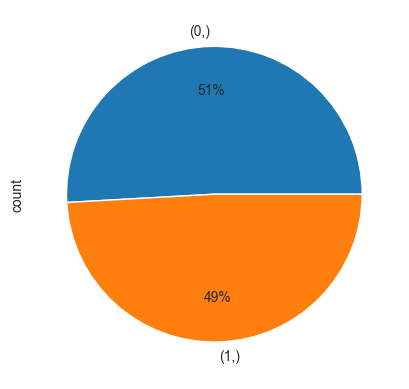

In [15]:
pd_yp_test.value_counts().plot.pie(autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.1)

## Polars Evaluation

In [16]:
pl_y_test.shape, pl_yp_test.shape

((1625, 1), (1625, 1))

[[0.50461538 0.        ]
 [0.00430769 0.49107692]]


Text(0.5, 23.52222222222222, 'Predicted Labels')

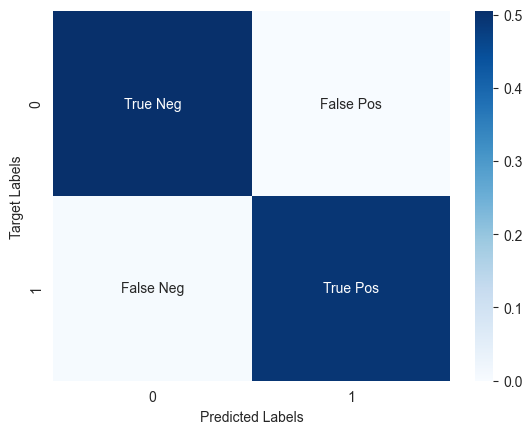

In [17]:
cf_matrix = confusion_matrix(pl_y_test, pl_yp_test)
print(cf_matrix/np.sum(cf_matrix))
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
fig, ax = plt.subplots(1, 1)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=labels, fmt='', cmap='Blues')
ax.set_ylabel('Target Labels')
ax.set_xlabel('Predicted Labels')

In [18]:
ri = rand_score(pl_y_test.to_numpy().flatten(), pl_yp_test.to_numpy().flatten())
ari = adjusted_rand_score(pl_y_test.to_numpy().flatten(), pl_yp_test.to_numpy().flatten())

print(f'Rand Index: {ri}')
print(f'Adjusted Rand Index: {ari}')

Rand Index: 0.9914164456233422
Adjusted Rand Index: 0.9828328885410909


In [19]:
True_neg = cf_matrix[0,0]
False_pos = cf_matrix[0,1]
True_pos = cf_matrix[1,1]
False_neg = cf_matrix[1,0]

accuracy = (True_neg + True_pos)/(True_neg + False_neg + True_pos + False_pos)
recall = (True_pos)/(False_neg+True_pos)
precision = (True_pos)/(False_pos + True_pos)
F1_score = 2 * ((precision*recall)/(precision+recall))
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1_score: {F1_score}')

Accuracy: 0.9956923076923077
Recall: 0.991304347826087
Precision: 1.0
F1_score: 0.9956331877729258


## Pandas Evaluation

[[0.50461538 0.        ]
 [0.00430769 0.49107692]]


Text(0.5, 23.52222222222222, 'Predicted Labels')

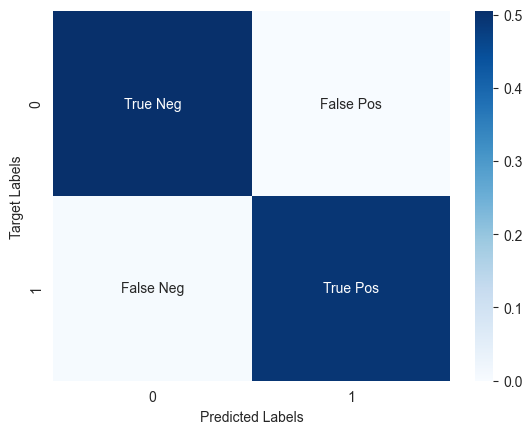

In [20]:
cf_matrix = confusion_matrix(pd_y_test, pd_yp_test)
print(cf_matrix/np.sum(cf_matrix))
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
fig, ax = plt.subplots(1, 1)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=labels, fmt='', cmap='Blues')
ax.set_ylabel('Target Labels')
ax.set_xlabel('Predicted Labels')

In [21]:
ri = rand_score(pd_y_test.values.reshape(1, -1)[0], pd_yp_test.values.reshape(1, -1)[0])
ari = adjusted_rand_score(pd_y_test.values.reshape(1, -1)[0], pd_yp_test.values.reshape(1, -1)[0])

print(f'Rand Index: {ri}')
print(f'Adjusted Rand Index: {ari}')

Rand Index: 0.9914164456233422
Adjusted Rand Index: 0.9828328885410909


In [22]:
True_neg = cf_matrix[0,0]
False_pos = cf_matrix[0,1]
True_pos = cf_matrix[1,1]
False_neg = cf_matrix[1,0]

accuracy = (True_neg + True_pos)/(True_neg + False_neg + True_pos + False_pos)
recall = (True_pos)/(False_neg+True_pos)
precision = (True_pos)/(False_pos + True_pos)
F1_score = 2 * ((precision*recall)/(precision+recall))
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1_score: {F1_score}')

Accuracy: 0.9956923076923077
Recall: 0.991304347826087
Precision: 1.0
F1_score: 0.9956331877729258
